In [8]:
from transformers import AutoTokenizer,AutoModel
import os
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [1]:
# Sample code-switching text (English + Hindi)
code_switching_examples = [
    "I enjoy khana khaana and coding in Python.",
    "Mujhe reading books pasand hai and I also like to code.",
    "Let's go to the market and buy some sabzi aur fruits.",
    "मैं नई भाषाएँ सीखना पसंद करता हूँ",         # Hindi
    "I love learning नई भाषाएँ 😃"                # Hinglish code-mix with emoji
]

def generate_embeddings(texts, model_name="sarvamai/sarvam-1", hf_token=None):
    """
    Generate embeddings for code-switching text using Sarvam AI's sarvam-1 model from Hugging Face.

    Args:
        texts (list): List of code-switching text strings.
        model_name (str): Hugging Face model name (e.g., sarvamai/sarvam-1).
        hf_token (str, optional): Hugging Face API token for private models.

    Returns:
        list: List of embedding vectors.
    """
    try:
        # Load tokenizer and model with optional token for private repos
        tokenizer = AutoTokenizer.from_pretrained(model_name, token=hf_token)

        # Set padding token to eos_token if not already set
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
            print(f"Set pad_token to eos_token: {tokenizer.pad_token}")

        model = AutoModel.from_pretrained(model_name, token=hf_token)

        # Move model to GPU if available
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        model.eval()

        embeddings = []
        for text in texts:
            # Tokenize input text
            inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
            inputs = {key: val.to(device) for key, val in inputs.items()}

            # Generate embeddings
            with torch.no_grad():
                outputs = model(**inputs)
                # Use mean of token embeddings for sentence-level representation
                embedding = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

            embeddings.append(embedding)

        return embeddings

    except Exception as e:
        print(f"Error generating embeddings: {e}")
        return None

def main():
    # Specify the Sarvam AI model from Hugging Face
    model_name = "sarvamai/sarvam-1"

    # Get Hugging Face token from environment (optional, for private models)
    hf_token = os.getenv("HF_TOKEN")

    print(f"Generating embeddings using {model_name}...")
    embeddings = generate_embeddings(code_switching_examples, model_name, hf_token)

    if embeddings is not None:
        # Print results
        for text, embedding in zip(code_switching_examples, embeddings):
            print(f"\nText: {text}")
            print(f"Embedding (first 5 values): {embedding[:5].tolist()}...")
            print(f"Embedding length: {len(embedding)}")
    else:
        print("Failed to generate embeddings.")

if __name__ == "__main__":
    main()

Generating embeddings using sarvamai/sarvam-1...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/775k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.51M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Set pad_token to eos_token: </s>


config.json:   0%|          | 0.00/717 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.77G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/279M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


Text: I enjoy khana khaana and coding in Python.
Embedding (first 5 values): [-0.34796345233917236, 0.1016358807682991, -0.25775259733200073, -0.31446292996406555, -0.3932451605796814]...
Embedding length: 2048

Text: Mujhe reading books pasand hai and I also like to code.
Embedding (first 5 values): [0.058487337082624435, 0.45004722476005554, 0.03068058378994465, -0.36254966259002686, -0.2438238263130188]...
Embedding length: 2048

Text: Let's go to the market and buy some sabzi aur fruits.
Embedding (first 5 values): [-0.16554908454418182, -0.01619197428226471, -0.5656647682189941, -0.5728837251663208, -0.7021635174751282]...
Embedding length: 2048

Text: मैं नई भाषाएँ सीखना पसंद करता हूँ
Embedding (first 5 values): [-0.05605747178196907, -0.12015876919031143, -0.4951443672180176, -0.4803628921508789, 0.44875961542129517]...
Embedding length: 2048

Text: I love learning नई भाषाएँ 😃
Embedding (first 5 values): [-0.10177909582853317, -0.049835700541734695, -0.5933712720870972, -0.0371

#testing embedding similarity

In [2]:
# Define test sentences
texts = [
    "I love learning new languages.",  # English
    "मैं नई भाषाएँ सीखना पसंद करता हूँ",  # Hindi
    "मैं love learning नई languages बहुत pasand करता हूँ"  # Hinglish
]

def generate_embeddings(texts, model_name="sarvamai/sarvam-1", hf_token=None):
    """
    Generate embeddings for a list of texts using Sarvam AI's sarvam-1 model.

    Args:
        texts (list): List of text strings (English, Hindi, Hinglish).
        model_name (str): Hugging Face model name (default: sarvamai/sarvam-1).
        hf_token (str, optional): Hugging Face API token for private models.

    Returns:
        torch.Tensor: Embeddings matrix of shape (num_texts, hidden_size).
    """
    try:
        # Load tokenizer and model
        tokenizer = AutoTokenizer.from_pretrained(model_name, token=hf_token)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
            print(f"Set pad_token to eos_token: {tokenizer.pad_token}")
        model = AutoModel.from_pretrained(model_name, token=hf_token)

        # Move model to GPU if available
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        model.eval()

        # Tokenize and generate embeddings
        inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {key: val.to(device) for key, val in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            # Mean-pool token embeddings for sentence-level representation
            embeddings = outputs.last_hidden_state.mean(dim=1)

        return embeddings

    except Exception as e:
        print(f"Error generating embeddings: {e}")
        return None

def test_embedding_similarity(texts, model_name="sarvamai/sarvam-1", hf_token=None):
    """
    Test cosine similarity between embeddings of multilingual sentences.

    Args:
        texts (list): List of text strings (English, Hindi, Hinglish).
        model_name (str): Hugging Face model name.
        hf_token (str, optional): Hugging Face API token.

    Returns:
        dict: Contains embedding shape, hidden_size, and cosine similarities.
    """
    try:
        # Generate embeddings
        embeddings = generate_embeddings(texts, model_name, hf_token)
        if embeddings is None:
            return None

        # Get hidden size from model configuration
        model = AutoModel.from_pretrained(model_name, token=hf_token)
        hidden_size = model.config.hidden_size

        # Compute cosine similarities
        cos_en_hi = F.cosine_similarity(embeddings[0], embeddings[1], dim=0).item()
        cos_en_hing = F.cosine_similarity(embeddings[0], embeddings[2], dim=0).item()
        cos_hi_hing = F.cosine_similarity(embeddings[1], embeddings[2], dim=0).item()

        # Verify embedding shape
        embedding_shape = embeddings.shape

        return {
            "embedding_shape": embedding_shape,
            "hidden_size": hidden_size,
            "cosine_sim_en_hi": cos_en_hi,
            "cosine_sim_en_hing": cos_en_hing,
            "cosine_sim_hi_hing": cos_hi_hing
        }

    except Exception as e:
        print(f"Error testing embedding similarity: {e}")
        return None

def main():
    model_name = "sarvamai/sarvam-1"
    hf_token = os.getenv("HF_TOKEN")

    print(f"Testing embedding similarity using {model_name}...")
    result = test_embedding_similarity(texts, model_name, hf_token)

    if result is not None:
        print(f"\nResults:")
        print(f"  Cosine similarity (English-Hindi): {result['cosine_sim_en_hi']:.4f}")
        print(f"  Cosine similarity (English-Hinglish): {result['cosine_sim_en_hing']:.4f}")
        print(f"  Cosine similarity (Hindi-Hinglish): {result['cosine_sim_hi_hing']:.4f}")

        # Interpret results
        if result['cosine_sim_en_hi'] > 0.7 and result['cosine_sim_en_hing'] > 0.7:
            print("  Success: Embeddings for English, Hindi, and Hinglish are close in vector space (cosine > 0.7).")
        else:
            print("  Warning: Embeddings may not be as close as expected (cosine < 0.7).")
    else:
        print("Failed to test embedding similarity.")

if __name__ == "__main__":
    main()

Testing embedding similarity using sarvamai/sarvam-1...
Set pad_token to eos_token: </s>


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


Results:
  Cosine similarity (English-Hindi): 0.5653
  Cosine similarity (English-Hinglish): 0.8144
  Cosine similarity (Hindi-Hinglish): 0.9105


##sarvamai/sarvam-1 **VS**  bert-base-uncased **VS** sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2

In [5]:
# Define test sentences
texts = [
    "I love learning new languages.",  # English
    "मैं नई भाषाएँ सीखना पसंद करता हूँ",  # Hindi
    "मैं love learning नई languages बहुत pasand करता हूँ"  # Hinglish
]

def generate_embeddings(texts, model_name="sarvamai/sarvam-1", hf_token=None):
    """
    Generate embeddings for a list of texts using the specified model.

    Args:
        texts (list): List of text strings (English, Hindi, Hinglish).
        model_name (str): Hugging Face model name.
        hf_token (str, optional): Hugging Face API token for private models.

    Returns:
        tuple: (embeddings, hidden_size) or (None, None) if error occurs.
    """
    try:
        # Load tokenizer and model
        tokenizer = AutoTokenizer.from_pretrained(model_name, token=hf_token)
        if "sarvam" in model_name and tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
            print(f"Set pad_token to eos_token for {model_name}: {tokenizer.pad_token}")
        model = AutoModel.from_pretrained(model_name, token=hf_token)

        # Get hidden size from model configuration
        hidden_size = model.config.hidden_size

        # Move model to GPU if available
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        model.eval()

        # Tokenize and generate embeddings
        inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {key: val.to(device) for key, val in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            # Mean-pool token embeddings for sentence-level representation
            embeddings = outputs.last_hidden_state.mean(dim=1)

        return embeddings, hidden_size

    except Exception as e:
        print(f"Error generating embeddings for {model_name}: {e}")
        return None, None

def compute_cosine_similarities(embeddings):
    """
    Compute cosine similarities between embeddings of English, Hindi, and Hinglish sentences.

    Args:
        embeddings (torch.Tensor): Embeddings matrix of shape (num_texts, hidden_size).

    Returns:
        dict: Cosine similarity scores for English-Hindi, English-Hinglish, Hindi-Hinglish.
    """
    cos_en_hi = F.cosine_similarity(embeddings[0], embeddings[1], dim=0).item()
    cos_en_hing = F.cosine_similarity(embeddings[0], embeddings[2], dim=0).item()
    cos_hi_hing = F.cosine_similarity(embeddings[1], embeddings[2], dim=0).item()

    return {
        "cosine_sim_en_hi": cos_en_hi,
        "cosine_sim_en_hing": cos_en_hing,
        "cosine_sim_hi_hing": cos_hi_hing
    }

def main():
    models = [
        ("sarvamai/sarvam-1", "Sarvam-1 (Indic-tuned multilingual)"),
        ("bert-base-uncased", "BERT (English monolingual)"),
        ("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2", "MiniLM (generic multilingual)")
    ]
    hf_token = os.getenv("HF_TOKEN")

    for model_name, model_desc in models:
        print(f"\nTesting embeddings with {model_desc}...")
        embeddings, hidden_size = generate_embeddings(texts, model_name, hf_token)

        if embeddings is not None:
            # Confirm embedding shape and hidden size
            print(f"  Embedding shape: {embeddings.shape}")
            print(f"  Model hidden_size: {hidden_size}")

            # Compute cosine similarities
            similarities = compute_cosine_similarities(embeddings)

            # Print results
            print(f"  Cosine similarity (English-Hindi): {similarities['cosine_sim_en_hi']:.4f}")
            print(f"  Cosine similarity (English-Hinglish): {similarities['cosine_sim_en_hing']:.4f}")
            print(f"  Cosine similarity (Hindi-Hinglish): {similarities['cosine_sim_hi_hing']:.4f}")

            # Interpret results
            if similarities['cosine_sim_en_hi'] > 0.7 and similarities['cosine_sim_en_hing'] > 0.7:
                print(f"  Success: {model_desc} captures semantic alignment (cosine > 0.7).")
            else:
                print(f"  Warning: {model_desc} may not capture semantic alignment well (cosine < 0.7).")
        else:
            print(f"  Failed to generate embeddings for {model_desc}.")

if __name__ == "__main__":
    main()


Testing embeddings with Sarvam-1 (Indic-tuned multilingual)...
Set pad_token to eos_token for sarvamai/sarvam-1: </s>


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Embedding shape: torch.Size([3, 2048])
  Model hidden_size: 2048
  Cosine similarity (English-Hindi): 0.5653
  Cosine similarity (English-Hinglish): 0.8144
  Cosine similarity (Hindi-Hinglish): 0.9105

Testing embeddings with BERT (English monolingual)...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

  Embedding shape: torch.Size([3, 768])
  Model hidden_size: 768
  Cosine similarity (English-Hindi): 0.2755
  Cosine similarity (English-Hinglish): 0.4798
  Cosine similarity (Hindi-Hinglish): 0.8828

Testing embeddings with MiniLM (generic multilingual)...


tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

  Embedding shape: torch.Size([3, 384])
  Model hidden_size: 384
  Cosine similarity (English-Hindi): 0.9335
  Cosine similarity (English-Hinglish): 0.9527
  Cosine similarity (Hindi-Hinglish): 0.9471
  Success: MiniLM (generic multilingual) captures semantic alignment (cosine > 0.7).


#finding most relevant doc

In [2]:
# Define documents and query
docs = [
    "The new irrigation techniques in agriculture are boosting crop yields.",  # English
    "नए irrigation के तरीके फसलों की पैदावार बढ़ा रहे हैं।",  # Hinglish
    "खेती में नई तकनीकों से फसल उत्पादन में वृद्धि हो रही है।"  # Hindi
]
query = "agriculture में best practices क्या हैं?"  # Hinglish query

def generate_embeddings(texts, model_name="sarvamai/sarvam-1", hf_token=None):
    """
    Generate embeddings for a list of texts using Sarvam AI's sarvam-1 model.

    Args:
        texts (list): List of text strings (documents or query).
        model_name (str): Hugging Face model name (default: sarvamai/sarvam-1).
        hf_token (str, optional): Hugging Face API token for private models.

    Returns:
        torch.Tensor: Embeddings matrix of shape (num_texts, embedding_dim).
    """
    try:
        # Load tokenizer and model
        tokenizer = AutoTokenizer.from_pretrained(model_name, token=hf_token)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
            print(f"Set pad_token to eos_token: {tokenizer.pad_token}")
        model = AutoModel.from_pretrained(model_name, token=hf_token)

        # Move model to GPU if available
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        model.eval()

        # Tokenize and generate embeddings
        inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {key: val.to(device) for key, val in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            # Mean-pool token embeddings for sentence-level representation
            embeddings = outputs.last_hidden_state.mean(dim=1)

        return embeddings

    except Exception as e:
        print(f"Error generating embeddings: {e}")
        return None

def compute_cosine_similarity(doc_vecs, query_vec):
    """
    Compute cosine similarity between document embeddings and query embedding.

    Args:
        doc_vecs (torch.Tensor): Document embeddings of shape (num_docs, embedding_dim).
        query_vec (torch.Tensor): Query embedding of shape (1, embedding_dim).

    Returns:
        torch.Tensor: Cosine similarity scores of shape (num_docs,).
    """
    # Normalize embeddings for cosine similarity
    doc_vecs_norm = doc_vecs / torch.norm(doc_vecs, dim=1, keepdim=True)
    query_vec_norm = query_vec / torch.norm(query_vec, dim=1, keepdim=True)
    # Compute cosine similarity (dot product of normalized vectors)
    scores = torch.matmul(doc_vecs_norm, query_vec_norm.T).squeeze(1)
    return scores

def main():
    model_name = "sarvamai/sarvam-1"
    hf_token = os.getenv("HF_TOKEN")

    print(f"Generating embeddings using {model_name}...")

    # Generate embeddings for documents and query
    doc_vecs = generate_embeddings(docs, model_name, hf_token)
    query_vec = generate_embeddings([query], model_name, hf_token)

    if doc_vecs is not None and query_vec is not None:
        # Compute cosine similarity
        scores = compute_cosine_similarity(doc_vecs, query_vec)

        # Rank documents by similarity
        best_idx = torch.argmax(scores).item()
        sorted_indices = torch.argsort(scores, descending=True)

        # Print results
        print(f"\nQuery: {query}")
        print("\nDocument relevance ranking:")
        for idx in sorted_indices:
            print(f"Doc: {docs[idx]} | Score: {scores[idx]:.4f}")
        print(f"\nMost relevant doc: {docs[best_idx]} (Score: {scores[best_idx]:.4f})")
    else:
        print("Failed to generate embeddings.")

if __name__ == "__main__":
    main()

Generating embeddings using sarvamai/sarvam-1...
Set pad_token to eos_token: </s>


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Set pad_token to eos_token: </s>


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


Query: agriculture में best practices क्या हैं?

Document relevance ranking:
Doc: The new irrigation techniques in agriculture are boosting crop yields. | Score: 0.8252
Doc: नए irrigation के तरीके फसलों की पैदावार बढ़ा रहे हैं। | Score: 0.8046
Doc: खेती में नई तकनीकों से फसल उत्पादन में वृद्धि हो रही है। | Score: 0.7091

Most relevant doc: The new irrigation techniques in agriculture are boosting crop yields. (Score: 0.8252)


#Checking hidden state dimensions

In [3]:
def check_hidden_state_dimension(model_name="sarvamai/sarvam-1", hf_token=None, test_texts=None):
    """
    Check the hidden state dimension of a model by inspecting its configuration and embeddings.

    Args:
        model_name (str): Hugging Face model name (default: sarvamai/sarvam-1).
        hf_token (str, optional): Hugging Face API token for private models.
        test_texts (list, optional): List of test texts to generate embeddings. If None, uses a default text.

    Returns:
        dict: Contains 'config_hidden_size' (from model config) and 'embedding_shape' (from output).
    """
    try:
        # Set default test text if none provided
        if test_texts is None:
            test_texts = ["I enjoy khana khaana and coding in Python."]

        # Load tokenizer and model
        tokenizer = AutoTokenizer.from_pretrained(model_name, token=hf_token)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
            print(f"Set pad_token to eos_token: {tokenizer.pad_token}")
        model = AutoModel.from_pretrained(model_name, token=hf_token)

        # Get hidden size from model configuration
        config_hidden_size = model.config.hidden_size
        print(f"Model configuration hidden_size: {config_hidden_size}")

        # Move model to GPU if available
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        model.eval()

        # Tokenize and generate embeddings
        inputs = tokenizer(test_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {key: val.to(device) for key, val in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            # Mean-pool token embeddings for sentence-level representation
            embeddings = outputs.last_hidden_state.mean(dim=1)

        # Get embedding shape
        embedding_shape = embeddings.shape
        print(f"Embedding tensor shape: {embedding_shape}")

        return {
            "config_hidden_size": config_hidden_size,
            "embedding_shape": embedding_shape
        }

    except Exception as e:
        print(f"Error checking hidden state dimension: {e}")
        return None

def main():
    # Use your documents for testing
    docs = [
        "The new irrigation techniques in agriculture are boosting crop yields.",
        "नए irrigation के तरीके फसलों की पैदावार बढ़ा रहे हैं।",
        "खेती में नई तकनीकों से फसल उत्पादन में वृद्धि हो रही है।"
    ]

    model_name = "sarvamai/sarvam-1"
    hf_token = os.getenv("HF_TOKEN")

    print(f"Checking hidden state dimension for {model_name}...")
    result = check_hidden_state_dimension(model_name, hf_token, docs)

    if result is not None:
        print(f"\nResults:")
        print(f"  Config hidden_size: {result['config_hidden_size']}")
        print(f"  Embedding shape: {result['embedding_shape']}")
        if result['embedding_shape'][1] == result['config_hidden_size']:
            print("  Confirmation: Embedding dimension matches config hidden_size.")
        else:
            print("  Warning: Embedding dimension does not match config hidden_size!")
    else:
        print("Failed to check hidden state dimension.")

if __name__ == "__main__":
    main()

Checking hidden state dimension for sarvamai/sarvam-1...
Set pad_token to eos_token: </s>


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model configuration hidden_size: 2048
Embedding tensor shape: torch.Size([3, 2048])

Results:
  Config hidden_size: 2048
  Embedding shape: torch.Size([3, 2048])
  Confirmation: Embedding dimension matches config hidden_size.


#Sarvam-1 vs MuRIL


Testing embeddings with Sarvam-1 (Indic-tuned multilingual)...
Set pad_token to eos_token for sarvamai/sarvam-1: </s>


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Embedding shape: torch.Size([3, 2048])
  Model hidden_size: 2048
  Cosine similarity (English-Hindi): 0.5653
  Cosine similarity (English-Hinglish): 0.8144
  Cosine similarity (Hindi-Hinglish): 0.9105


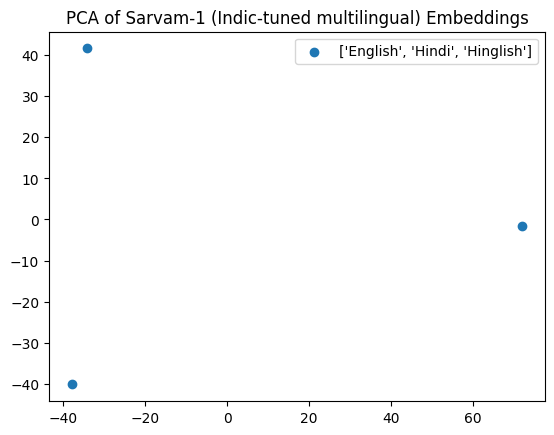


Testing embeddings with MuRIL (Indian languages multilingual)...
  Embedding shape: torch.Size([3, 768])
  Model hidden_size: 768
  Cosine similarity (English-Hindi): 0.9943
  Cosine similarity (English-Hinglish): 0.9940
  Cosine similarity (Hindi-Hinglish): 0.9960
  Success: MuRIL (Indian languages multilingual) captures semantic alignment (cosine > 0.7).


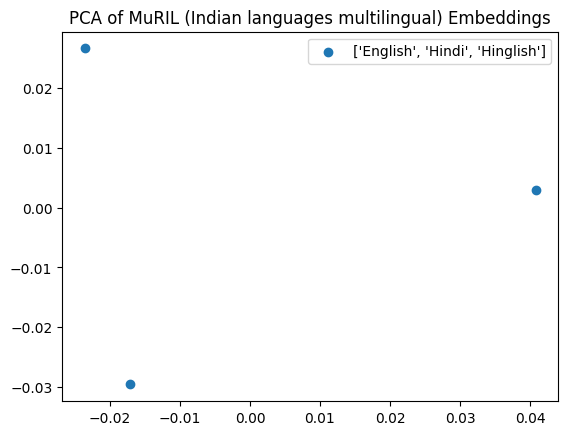

In [4]:
# Define test sentences
texts = [
    "I love learning new languages.",  # English
    "मैं नई भाषाएँ सीखना पसंद करता हूँ",  # Hindi
    "मैं love learning नई languages बहुत pasand करता हूँ"  # Hinglish
]

def generate_embeddings(texts, model_name="sarvamai/sarvam-1", hf_token=None):
    """
    Generate embeddings for a list of texts using the specified model.

    Args:
        texts (list): List of text strings (English, Hindi, Hinglish).
        model_name (str): Hugging Face model name.
        hf_token (str, optional): Hugging Face API token for private models.

    Returns:
        tuple: (embeddings, hidden_size) or (None, None) if error occurs.
    """
    try:
        # Load tokenizer and model
        tokenizer = AutoTokenizer.from_pretrained(model_name, token=hf_token)
        if "sarvam" in model_name and tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
            print(f"Set pad_token to eos_token for {model_name}: {tokenizer.pad_token}")
        model = AutoModel.from_pretrained(model_name, token=hf_token)

        # Get hidden size from model configuration
        hidden_size = model.config.hidden_size

        # Move model to GPU if available
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        model.eval()

        # Tokenize and generate embeddings
        inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {key: val.to(device) for key, val in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            # Mean-pool token embeddings for sentence-level representation
            embeddings = outputs.last_hidden_state.mean(dim=1)

        return embeddings, hidden_size

    except Exception as e:
        print(f"Error generating embeddings for {model_name}: {e}")
        return None, None

def compute_cosine_similarities(embeddings):
    """
    Compute cosine similarities between embeddings of English, Hindi, and Hinglish sentences.

    Args:
        embeddings (torch.Tensor): Embeddings matrix of shape (num_texts, hidden_size).

    Returns:
        dict: Cosine similarity scores for English-Hindi, English-Hinglish, Hindi-Hinglish.
    """
    cos_en_hi = F.cosine_similarity(embeddings[0], embeddings[1], dim=0).item()
    cos_en_hing = F.cosine_similarity(embeddings[0], embeddings[2], dim=0).item()
    cos_hi_hing = F.cosine_similarity(embeddings[1], embeddings[2], dim=0).item()

    return {
        "cosine_sim_en_hi": cos_en_hi,
        "cosine_sim_en_hing": cos_en_hing,
        "cosine_sim_hi_hing": cos_hi_hing
    }

def main():
    models = [
        ("sarvamai/sarvam-1", "Sarvam-1 (Indic-tuned multilingual)"),
        ("google/muril-base-cased", "MuRIL (Indian languages multilingual)")
    ]
    hf_token = os.getenv("HF_TOKEN")

    for model_name, model_desc in models:
        print(f"\nTesting embeddings with {model_desc}...")
        embeddings, hidden_size = generate_embeddings(texts, model_name, hf_token)

        if embeddings is not None:
            # Confirm embedding shape and hidden size
            print(f"  Embedding shape: {embeddings.shape}")
            print(f"  Model hidden_size: {hidden_size}")

            # Compute cosine similarities
            similarities = compute_cosine_similarities(embeddings)

            # Print results
            print(f"  Cosine similarity (English-Hindi): {similarities['cosine_sim_en_hi']:.4f}")
            print(f"  Cosine similarity (English-Hinglish): {similarities['cosine_sim_en_hing']:.4f}")
            print(f"  Cosine similarity (Hindi-Hinglish): {similarities['cosine_sim_hi_hing']:.4f}")

            # Interpret results
            if similarities['cosine_sim_en_hi'] > 0.7 and similarities['cosine_sim_en_hing'] > 0.7:
                print(f"  Success: {model_desc} captures semantic alignment (cosine > 0.7).")
            else:
                print(f"  Warning: {model_desc} may not capture semantic alignment well (cosine < 0.7).")
            embeddings_np = embeddings.cpu().numpy()
            pca = PCA(n_components=2)
            reduced = pca.fit_transform(embeddings_np)
            plt.scatter(reduced[:, 0], reduced[:, 1], label=['English', 'Hindi', 'Hinglish'])
            plt.title(f"PCA of {model_desc} Embeddings")
            plt.legend()
            plt.show()
        else:
            print(f"  Failed to generate embeddings for {model_desc}.")

if __name__ == "__main__":
    main()

In [5]:
# Define Hinglish test sentence
hinglish_sentence = "मैं love learning नई languages बहुत pasand करता हूँ"

def compare_tokenization(sentence, models):
    """
    Compare tokenization of a sentence across multiple models.

    Args:
        sentence (str): Input sentence (e.g., Hinglish).
        models (list): List of (model_name, model_desc) tuples.

    Returns:
        dict: Tokenization results with model names, token counts, and tokenized outputs.
    """
    results = {}
    for model_name, model_desc in models:
        try:
            # Load tokenizer
            tokenizer = AutoTokenizer.from_pretrained(model_name)

            # Tokenize the sentence
            tokens = tokenizer.tokenize(sentence)
            token_count = len(tokens)
            token_ids = tokenizer.encode(sentence, add_special_tokens=True)

            # Convert token IDs back to tokens for display
            decoded_tokens = [tokenizer.convert_ids_to_tokens(id) for id in token_ids]

            results[model_name] = {
                "description": model_desc,
                "token_count": token_count,
                "tokens": tokens,
                "decoded_tokens_with_special": decoded_tokens
            }

        except Exception as e:
            print(f"Error tokenizing with {model_desc}: {e}")
            results[model_name] = {"error": str(e)}

    return results

def main():
    models = [
        ("sarvamai/sarvam-1", "Sarvam-1 (Indic-tuned multilingual)"),
        ("bert-base-multilingual-cased", "mBERT (generic multilingual)"),
        ("xlm-roberta-base", "XLM-R (generic multilingual)")
    ]

    print(f"Comparing tokenization for sentence: '{hinglish_sentence}'")
    results = compare_tokenization(hinglish_sentence, models)

    for model_name, result in results.items():
        print(f"\nModel: {result['description']}")
        if "error" in result:
            print(f"  Error: {result['error']}")
        else:
            print(f"  Token count: {result['token_count']}")
            print(f"  Tokens: {result['tokens']}")
            print(f"  Decoded tokens (with special tokens): {result['decoded_tokens_with_special']}")

if __name__ == "__main__":
    main()

Comparing tokenization for sentence: 'मैं love learning नई languages बहुत pasand करता हूँ'


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]


Model: Sarvam-1 (Indic-tuned multilingual)
  Token count: 11
  Tokens: ['▁मैं', '▁love', '▁learning', '▁नई', '▁languages', '▁बहुत', '▁p', 'as', 'and', '▁करता', '▁हूँ']
  Decoded tokens (with special tokens): ['<s>', '▁मैं', '▁love', '▁learning', '▁नई', '▁languages', '▁बहुत', '▁p', 'as', 'and', '▁करता', '▁हूँ']

Model: mBERT (generic multilingual)
  Token count: 13
  Tokens: ['म', '##ैं', 'love', 'learning', 'नई', 'languages', 'बहुत', 'pasa', '##nd', 'करता', 'ह', '##ू', '##ँ']
  Decoded tokens (with special tokens): ['[CLS]', 'म', '##ैं', 'love', 'learning', 'नई', 'languages', 'बहुत', 'pasa', '##nd', 'करता', 'ह', '##ू', '##ँ', '[SEP]']

Model: XLM-R (generic multilingual)
  Token count: 11
  Tokens: ['▁मैं', '▁love', '▁learning', '▁नई', '▁language', 's', '▁बहुत', '▁pas', 'and', '▁करता', '▁हूँ']
  Decoded tokens (with special tokens): ['<s>', '▁मैं', '▁love', '▁learning', '▁नई', '▁language', 's', '▁बहुत', '▁pas', 'and', '▁करता', '▁हूँ', '</s>']


In [ ]:
complex_sentence = "मैं आज office में काम करता हूँ, Tamil में பேசுகிறேன் (pesukiren), और फिर English movies देखता हूँ।"

In [7]:
# Define Hinglish test sentence
hinglish_sentence = "Main enjoy ਕਰਦਾ हूँ watching movies with my Punjabi friends on weekends."

def compare_tokenization(sentence, models):
    """
    Compare tokenization of a sentence across multiple models.

    Args:
        sentence (str): Input sentence (e.g., Hinglish).
        models (list): List of (model_name, model_desc) tuples.

    Returns:
        dict: Tokenization results with model names, token counts, and tokenized outputs.
    """
    results = {}
    for model_name, model_desc in models:
        try:
            # Load tokenizer
            tokenizer = AutoTokenizer.from_pretrained(model_name)

            # Tokenize the sentence
            tokens = tokenizer.tokenize(sentence)
            token_count = len(tokens)
            token_ids = tokenizer.encode(sentence, add_special_tokens=True)

            # Convert token IDs back to tokens for display
            decoded_tokens = [tokenizer.convert_ids_to_tokens(id) for id in token_ids]

            results[model_name] = {
                "description": model_desc,
                "token_count": token_count,
                "tokens": tokens,
                "decoded_tokens_with_special": decoded_tokens
            }

        except Exception as e:
            print(f"Error tokenizing with {model_desc}: {e}")
            results[model_name] = {"error": str(e)}

    return results

def main():
    models = [
        ("sarvamai/sarvam-1", "Sarvam-1 (Indic-tuned multilingual)"),
        ("bert-base-multilingual-cased", "mBERT (generic multilingual)"),
        ("xlm-roberta-base", "XLM-R (generic multilingual)")
    ]

    print(f"Comparing tokenization for sentence: '{hinglish_sentence}'")
    results = compare_tokenization(hinglish_sentence, models)

    for model_name, result in results.items():
        print(f"\nModel: {result['description']}")
        if "error" in result:
            print(f"  Error: {result['error']}")
        else:
            print(f"  Token count: {result['token_count']}")
            print(f"  Tokens: {result['tokens']}")
            print(f"  Decoded tokens (with special tokens): {result['decoded_tokens_with_special']}")

if __name__ == "__main__":
    main()

Comparing tokenization for sentence: 'Main enjoy ਕਰਦਾ हूँ watching movies with my Punjabi friends on weekends.'

Model: Sarvam-1 (Indic-tuned multilingual)
  Token count: 17
  Tokens: ['▁Main', '▁enjoy', '▁ਕਰਦਾ', '▁हूँ', '▁watching', '▁movies', '▁with', '▁my', '▁P', 'un', 'j', 'abi', '▁friends', '▁on', '▁week', 'ends', '.']
  Decoded tokens (with special tokens): ['<s>', '▁Main', '▁enjoy', '▁ਕਰਦਾ', '▁हूँ', '▁watching', '▁movies', '▁with', '▁my', '▁P', 'un', 'j', 'abi', '▁friends', '▁on', '▁week', 'ends', '.']

Model: mBERT (generic multilingual)
  Token count: 16
  Tokens: ['Main', 'enjoy', 'ਕਰਦਾ', 'ह', '##ू', '##ँ', 'watching', 'movies', 'with', 'my', 'Punjabi', 'friends', 'on', 'weekend', '##s', '.']
  Decoded tokens (with special tokens): ['[CLS]', 'Main', 'enjoy', 'ਕਰਦਾ', 'ह', '##ू', '##ँ', 'watching', 'movies', 'with', 'my', 'Punjabi', 'friends', 'on', 'weekend', '##s', '.', '[SEP]']

Model: XLM-R (generic multilingual)
  Token count: 14
  Tokens: ['▁Main', '▁enjoy', '▁ਕਰਦਾ', '▁हू